import packages

In [1]:
import pandas as pd
import numpy as np
import math
from collections import Counter
import random
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

build synthetic dataset

In [2]:
seed = 42
np.random.seed(seed)
random.seed(42)

#original loan amount
#credit score
#ltv
#vehicle_type
#number of late payments
#loan_default

In [3]:
min_loan = 4000
max_loan = 75000
n_loans = 1000

orig_loan_bal = []

for i in np.arange(0, n_loans, 1):
    orig_bal = np.random.randint(min_loan, max_loan)
    orig_bal = round(orig_bal, -2)
    orig_loan_bal.append(orig_bal)

In [4]:
# Start with credit scores
credit_scores = np.random.normal(680, 80, 1000)
orig_credit_score = np.clip(credit_scores, 550, 850)

In [5]:
min_ltv = 50
max_ltv = 120

orig_ltv = []

for i in orig_credit_score:
    ltv = 120 - (i - 550) * 0.15
    noise = np.random.normal(-10, 10)
    ltv = ltv + noise
    ltv = np.clip(ltv, 60, 130)
    orig_ltv.append(ltv)

In [6]:
# Late payments strongly inversely related to credit score
late_payment_prob = 1 / (1 + np.exp((credit_scores - 600) / 50))
late_payments = np.random.poisson(late_payment_prob * 3, n_loans)
orig_late_payments = np.clip(late_payments, 0, 6)

In [7]:
vehicle_types = ['NEW', 'USED']
weight = [0.3, 0.7]
orig_vehicle_type = random.choices(vehicle_types, weights=weight, k=n_loans)

In [8]:
# Default probability based on multiple factors
default_logit = (-3 +
                (late_payments * 0.8) +          # Strong impact
                ((ltv - 90) * 0.03) +              # LTV impact  
                ((680 - credit_scores) * 0.01) +   # Credit score impact
                (np.where(orig_vehicle_type == "NEW", -0.06, 0.01)) +                  # Vehicle type impact
                (-0.04 * (np.array(orig_loan_bal) - min_loan) / (max_loan - min_loan)) +
                np.random.normal(-0.01, 0.10, n_loans)   #Adding some noise?
                )
default_prob = 1 / (1 + np.exp(-default_logit))

defaults = np.random.binomial(1, default_prob, n_loans)



In [9]:


loan_data = pd.DataFrame({
    'original_loan_amount': orig_loan_bal,
    'credit_score': orig_credit_score,
    'ltv': orig_ltv,
    'vehicle_type': orig_vehicle_type,
    'late_payments': orig_late_payments,
    'loan_default': defaults
})

In [10]:
loan_data.loan_default.value_counts()

loan_default
0    855
1    145
Name: count, dtype: int64

In [11]:
# Check vehicle type vs default rates
print(loan_data.groupby('vehicle_type')['loan_default'].agg(['count', 'mean']))

              count      mean
vehicle_type                 
NEW             295  0.138983
USED            705  0.147518


In [12]:
# See if credit score and vehicle type are correlated
print("Average credit score by vehicle type:")
print(loan_data.groupby('vehicle_type')['credit_score'].mean())

# Check credit score distribution in defaults vs non-defaults
print("Credit score by default status:")
print(loan_data.groupby('loan_default')['credit_score'].agg(['mean', 'std']))

Average credit score by vehicle type:
vehicle_type
NEW     685.126198
USED    680.848610
Name: credit_score, dtype: float64
Credit score by default status:
                    mean        std
loan_default                       
0             694.344662  71.453141
1             609.971120  58.760259


Decision Tree Building

In [13]:
#encode vehicle type
loan_data['vehicle_type_encoded'] = loan_data['vehicle_type'].map({'NEW': 0, 'USED': 1})


X = loan_data[['original_loan_amount', 'credit_score', 'ltv', 'late_payments', 'vehicle_type_encoded']]
y = loan_data['loan_default']

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [15]:
clf = DecisionTreeClassifier(max_depth = 4, random_state=seed)
clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [16]:
# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.85


Features: ['original_loan_amount', 'credit_score', 'ltv', 'late_payments', 'vehicle_type_encoded']
Tree depth: 4
Number of leaves: 14
                feature  importance
3         late_payments    0.613528
1          credit_score    0.336896
2                   ltv    0.040345
0  original_loan_amount    0.009231
4  vehicle_type_encoded    0.000000


Text(0.5, 1.0, 'Feature Importances')

<Figure size 1500x1000 with 0 Axes>

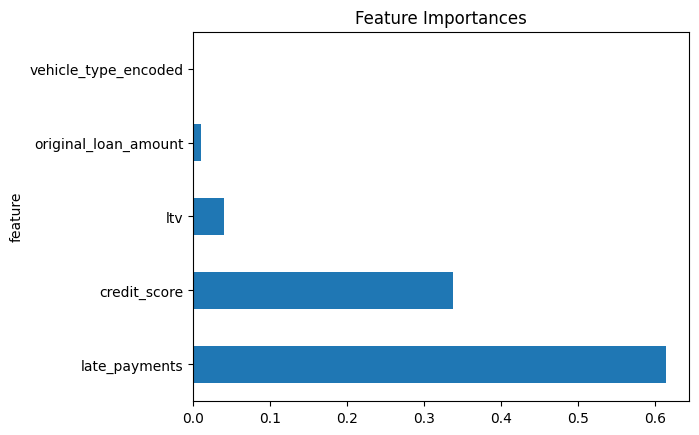

In [17]:
# Check what features you're actually using
print("Features:", X.columns.tolist())

# Look at the decision tree depth/complexity
print("Tree depth:", clf.get_depth())
print("Number of leaves:", clf.get_n_leaves())

# Check feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance)
plt.figure(figsize=(15, 10))
feature_importance.plot(kind='barh', x='feature', y='importance', legend=False)
plt.title('Feature Importances')

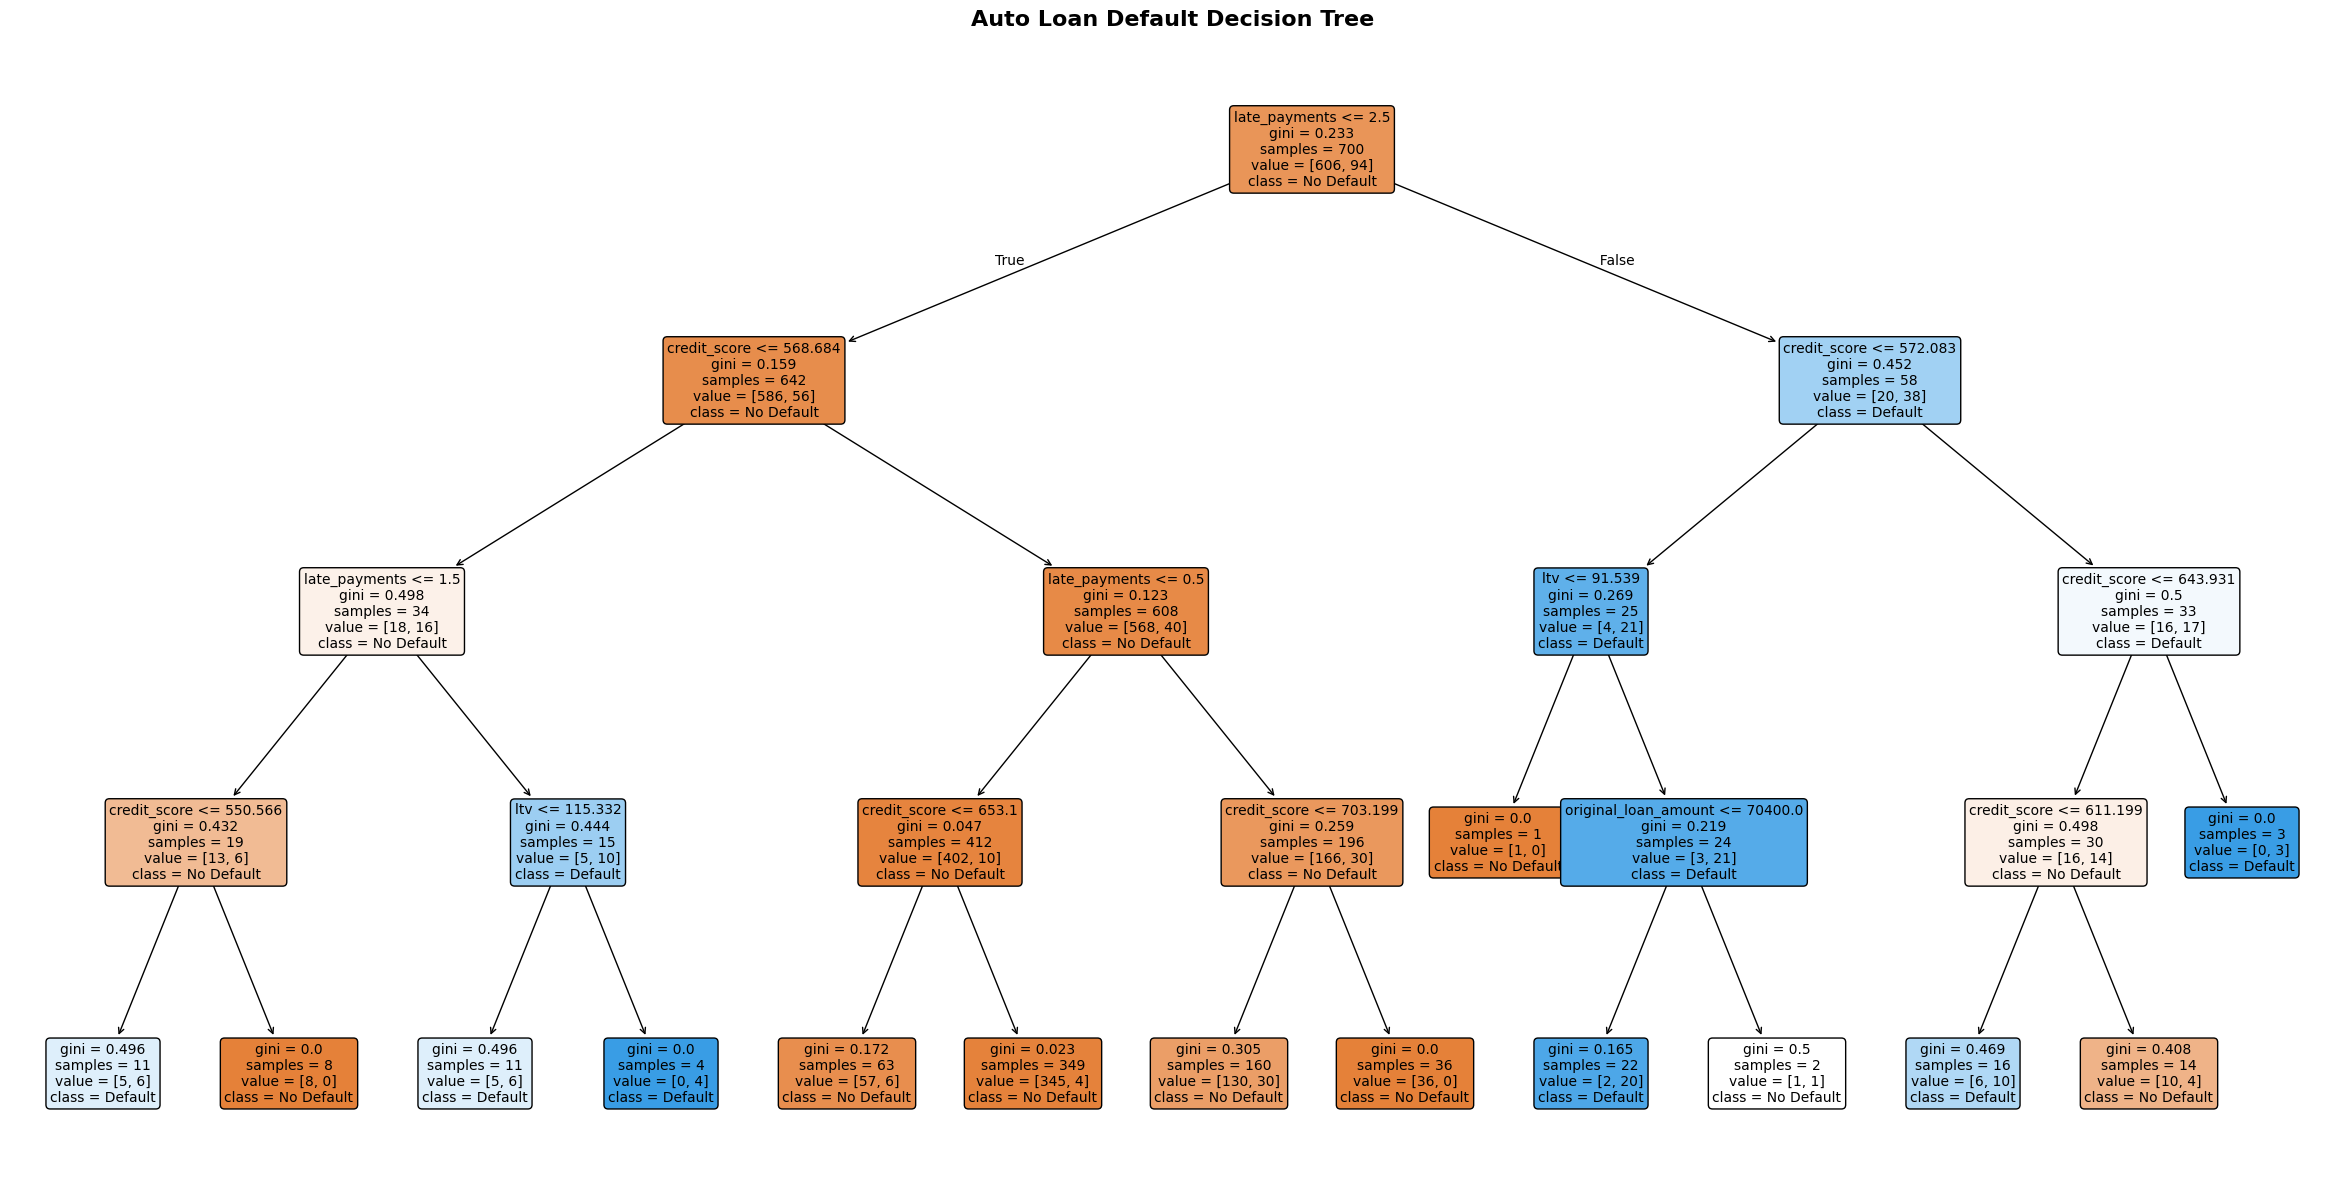

In [18]:
# Create a large, readable tree visualization
plt.figure(figsize=(30, 15))
plot_tree(clf, 
          feature_names=X.columns, 
          class_names=['No Default', 'Default'], 
          filled=True, 
          rounded=True,
          fontsize=10)
plt.title('Auto Loan Default Decision Tree', fontsize=16, fontweight='bold')
plt.show()

Hyperparameter Tuning

Max Depth: 1 | Accuracy: 0.85
Max Depth: 2 | Accuracy: 0.85
Max Depth: 3 | Accuracy: 0.87
Max Depth: 4 | Accuracy: 0.85
Max Depth: 5 | Accuracy: 0.86
Max Depth: 6 | Accuracy: 0.85
Max Depth: 7 | Accuracy: 0.85
Max Depth: 8 | Accuracy: 0.84


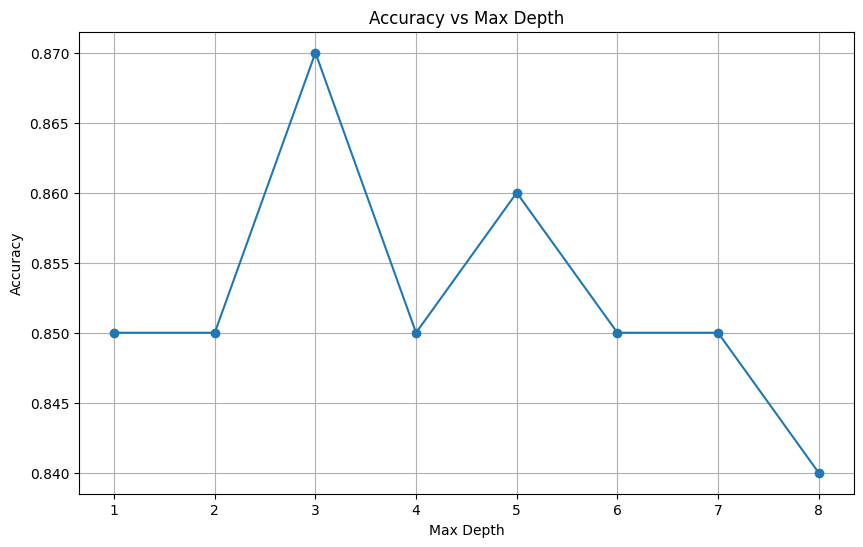

In [19]:
# max_depth can be tuned to control overfitting/underfitting
# Experiment with different max_depth values and observe accuracy and tree complexity

m_depth = range(1,9)

max_depth_list = []
accuracy_list = []

for i in m_depth:
    #establish model
    clf = DecisionTreeClassifier(max_depth = i, random_state=seed)
    #fit model
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    print(f"Max Depth: {i} | Accuracy: {accuracy}")
    max_depth_list.append(i)
    accuracy_list.append(accuracy)

    #1 to 5 is actually optimal
plt.figure(figsize=(10, 6))
plt.plot(max_depth_list, accuracy_list, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth')
plt.grid(True)
plt.show()

In [20]:
#max_depth: range(1,6)           # 8 values
#min_samples_split: np.arange(2, 20, 1)    # 18 values  
#min_samples_leaf: np.arange(1, 21, 1)     # 20 values
#max_features: np.arange(1, 6, 1)          # 4 values

Min Samples Split: 2 | Accuracy: 0.83
Min Samples Split: 3 | Accuracy: 0.82
Min Samples Split: 4 | Accuracy: 0.8
Min Samples Split: 5 | Accuracy: 0.82
Min Samples Split: 6 | Accuracy: 0.82
Min Samples Split: 7 | Accuracy: 0.82
Min Samples Split: 8 | Accuracy: 0.82
Min Samples Split: 9 | Accuracy: 0.82
Min Samples Split: 10 | Accuracy: 0.82
Min Samples Split: 11 | Accuracy: 0.82
Min Samples Split: 12 | Accuracy: 0.81
Min Samples Split: 13 | Accuracy: 0.83
Min Samples Split: 14 | Accuracy: 0.82
Min Samples Split: 15 | Accuracy: 0.82
Min Samples Split: 16 | Accuracy: 0.82
Min Samples Split: 17 | Accuracy: 0.81
Min Samples Split: 18 | Accuracy: 0.81
Min Samples Split: 19 | Accuracy: 0.81
Min Samples Split: 20 | Accuracy: 0.82
Min Samples Split: 21 | Accuracy: 0.82
Min Samples Split: 22 | Accuracy: 0.81
Min Samples Split: 23 | Accuracy: 0.81
Min Samples Split: 24 | Accuracy: 0.81
Min Samples Split: 25 | Accuracy: 0.82
Min Samples Split: 26 | Accuracy: 0.82
Min Samples Split: 27 | Accuracy: 

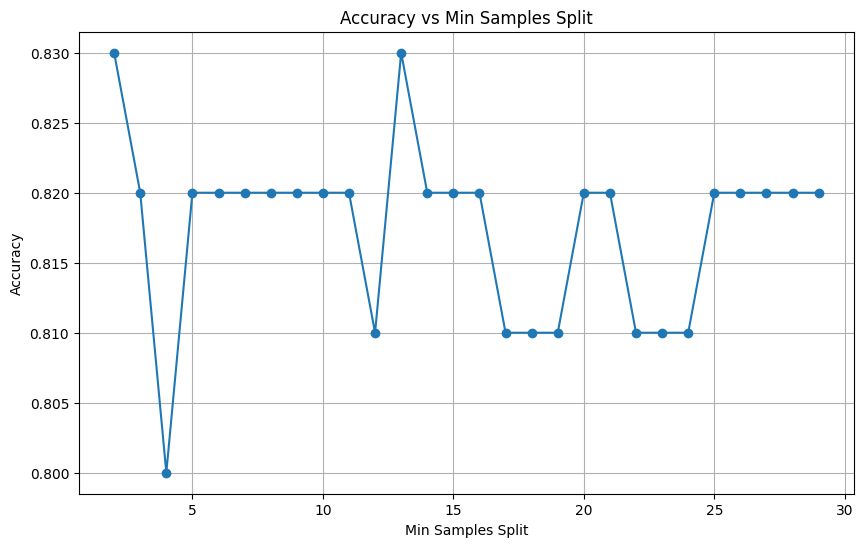

In [21]:
m_samples_split = np.arange(2, 30, 1) 

m_samples_split_list = []
accuracy_split_list = []

for i in m_samples_split:
    #establish model
    clf = DecisionTreeClassifier(min_samples_split = i, random_state=seed)
    #fit model
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    print(f"Min Samples Split: {i} | Accuracy: {accuracy}")

    m_samples_split_list.append(i)
    accuracy_split_list.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(m_samples_split_list, accuracy_split_list, marker='o')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Min Samples Split')
plt.grid(True)
plt.show()

Min Samples Leaf: 1 | Accuracy: 0.83
Min Samples Leaf: 2 | Accuracy: 0.83
Min Samples Leaf: 3 | Accuracy: 0.83
Min Samples Leaf: 4 | Accuracy: 0.85
Min Samples Leaf: 5 | Accuracy: 0.84
Min Samples Leaf: 6 | Accuracy: 0.83
Min Samples Leaf: 7 | Accuracy: 0.84
Min Samples Leaf: 8 | Accuracy: 0.84
Min Samples Leaf: 9 | Accuracy: 0.83
Min Samples Leaf: 10 | Accuracy: 0.83
Min Samples Leaf: 11 | Accuracy: 0.84
Min Samples Leaf: 12 | Accuracy: 0.85
Min Samples Leaf: 13 | Accuracy: 0.85
Min Samples Leaf: 14 | Accuracy: 0.85
Min Samples Leaf: 15 | Accuracy: 0.85
Min Samples Leaf: 16 | Accuracy: 0.85
Min Samples Leaf: 17 | Accuracy: 0.86
Min Samples Leaf: 18 | Accuracy: 0.85
Min Samples Leaf: 19 | Accuracy: 0.85
Min Samples Leaf: 20 | Accuracy: 0.85
Min Samples Leaf: 21 | Accuracy: 0.85
Min Samples Leaf: 22 | Accuracy: 0.85
Min Samples Leaf: 23 | Accuracy: 0.85
Min Samples Leaf: 24 | Accuracy: 0.85
Min Samples Leaf: 25 | Accuracy: 0.85
Min Samples Leaf: 26 | Accuracy: 0.85
Min Samples Leaf: 27 

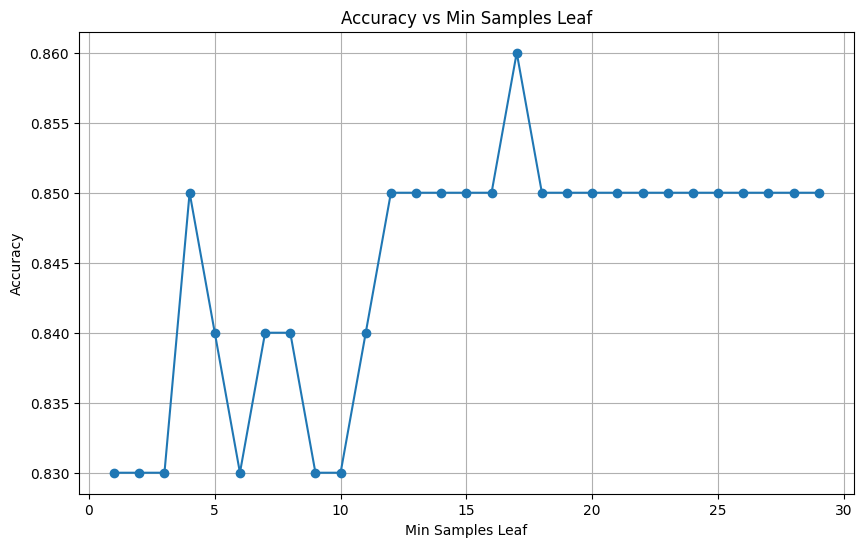

In [22]:
m_samples_leaf = np.arange(1, 30, 1) 

m_samples_leaf_list = []
accuracy_leaf_list = []

for i in m_samples_leaf:
    #establish model
    clf = DecisionTreeClassifier(min_samples_leaf = i, random_state=seed)
    #fit model
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    print(f"Min Samples Leaf: {i} | Accuracy: {accuracy}")

    m_samples_leaf_list.append(i)
    accuracy_leaf_list.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(m_samples_leaf_list, accuracy_leaf_list, marker='o')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Min Samples Leaf')
plt.grid(True)
plt.show()

gridsearchCV method

In [23]:
# Define the hyperparameters and their potential values in a dictionary (param_grid)
param_grid = {
    'max_depth': range(1,9),
    'min_samples_split': np.arange(2, 30, 1),
    'min_samples_leaf': np.arange(1, 30, 1)
}

clf = DecisionTreeClassifier(random_state=seed)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy', # Choose an appropriate metric (e.g., 'accuracy', 'f1', 'neg_mean_squared_error')
    cv=5,               # Use 5-fold cross-validation (a common choice)
    verbose=1,          # Optional: controls the amount of logging output
    n_jobs=-1           # Optional: uses all available processor cores for parallel processing
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6496 candidates, totalling 32480 fits


,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': range(1, 9), 'min_samples_leaf': array([ 1, 2..., 27, 28, 29]), 'min_samples_split': array([ 2, 3..., 27, 28, 29])}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [24]:
# Print the best parameters
print(f"Best parameters found: {grid_search.best_params_}")

# Print the best cross-validation score
print(f"Best CV score: {round(grid_search.best_score_, 4)}")

# Access the best estimator (model) directly
best_model = grid_search.best_estimator_

# Evaluate the best model on the hold-out test set
test_score = round(best_model.score(X_test, y_test), 4)
print(f"Test set accuracy with best model: {test_score}")


Best parameters found: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 7}
Best CV score: 0.8871
Test set accuracy with best model: 0.84


Run best model

Accuracy: 0.8533333333333334
Features: ['original_loan_amount', 'credit_score', 'ltv', 'late_payments', 'vehicle_type_encoded']
Tree depth: 6
Number of leaves: 32
                feature  importance
3         late_payments    0.495269
1          credit_score    0.316854
0  original_loan_amount    0.106921
2                   ltv    0.080955
4  vehicle_type_encoded    0.000000


<Figure size 1500x1000 with 0 Axes>

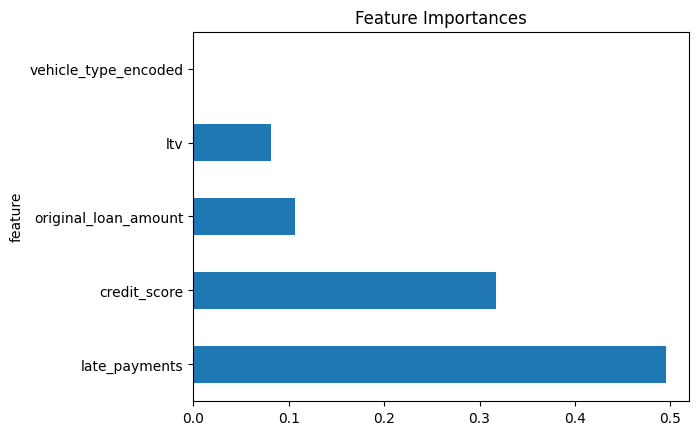

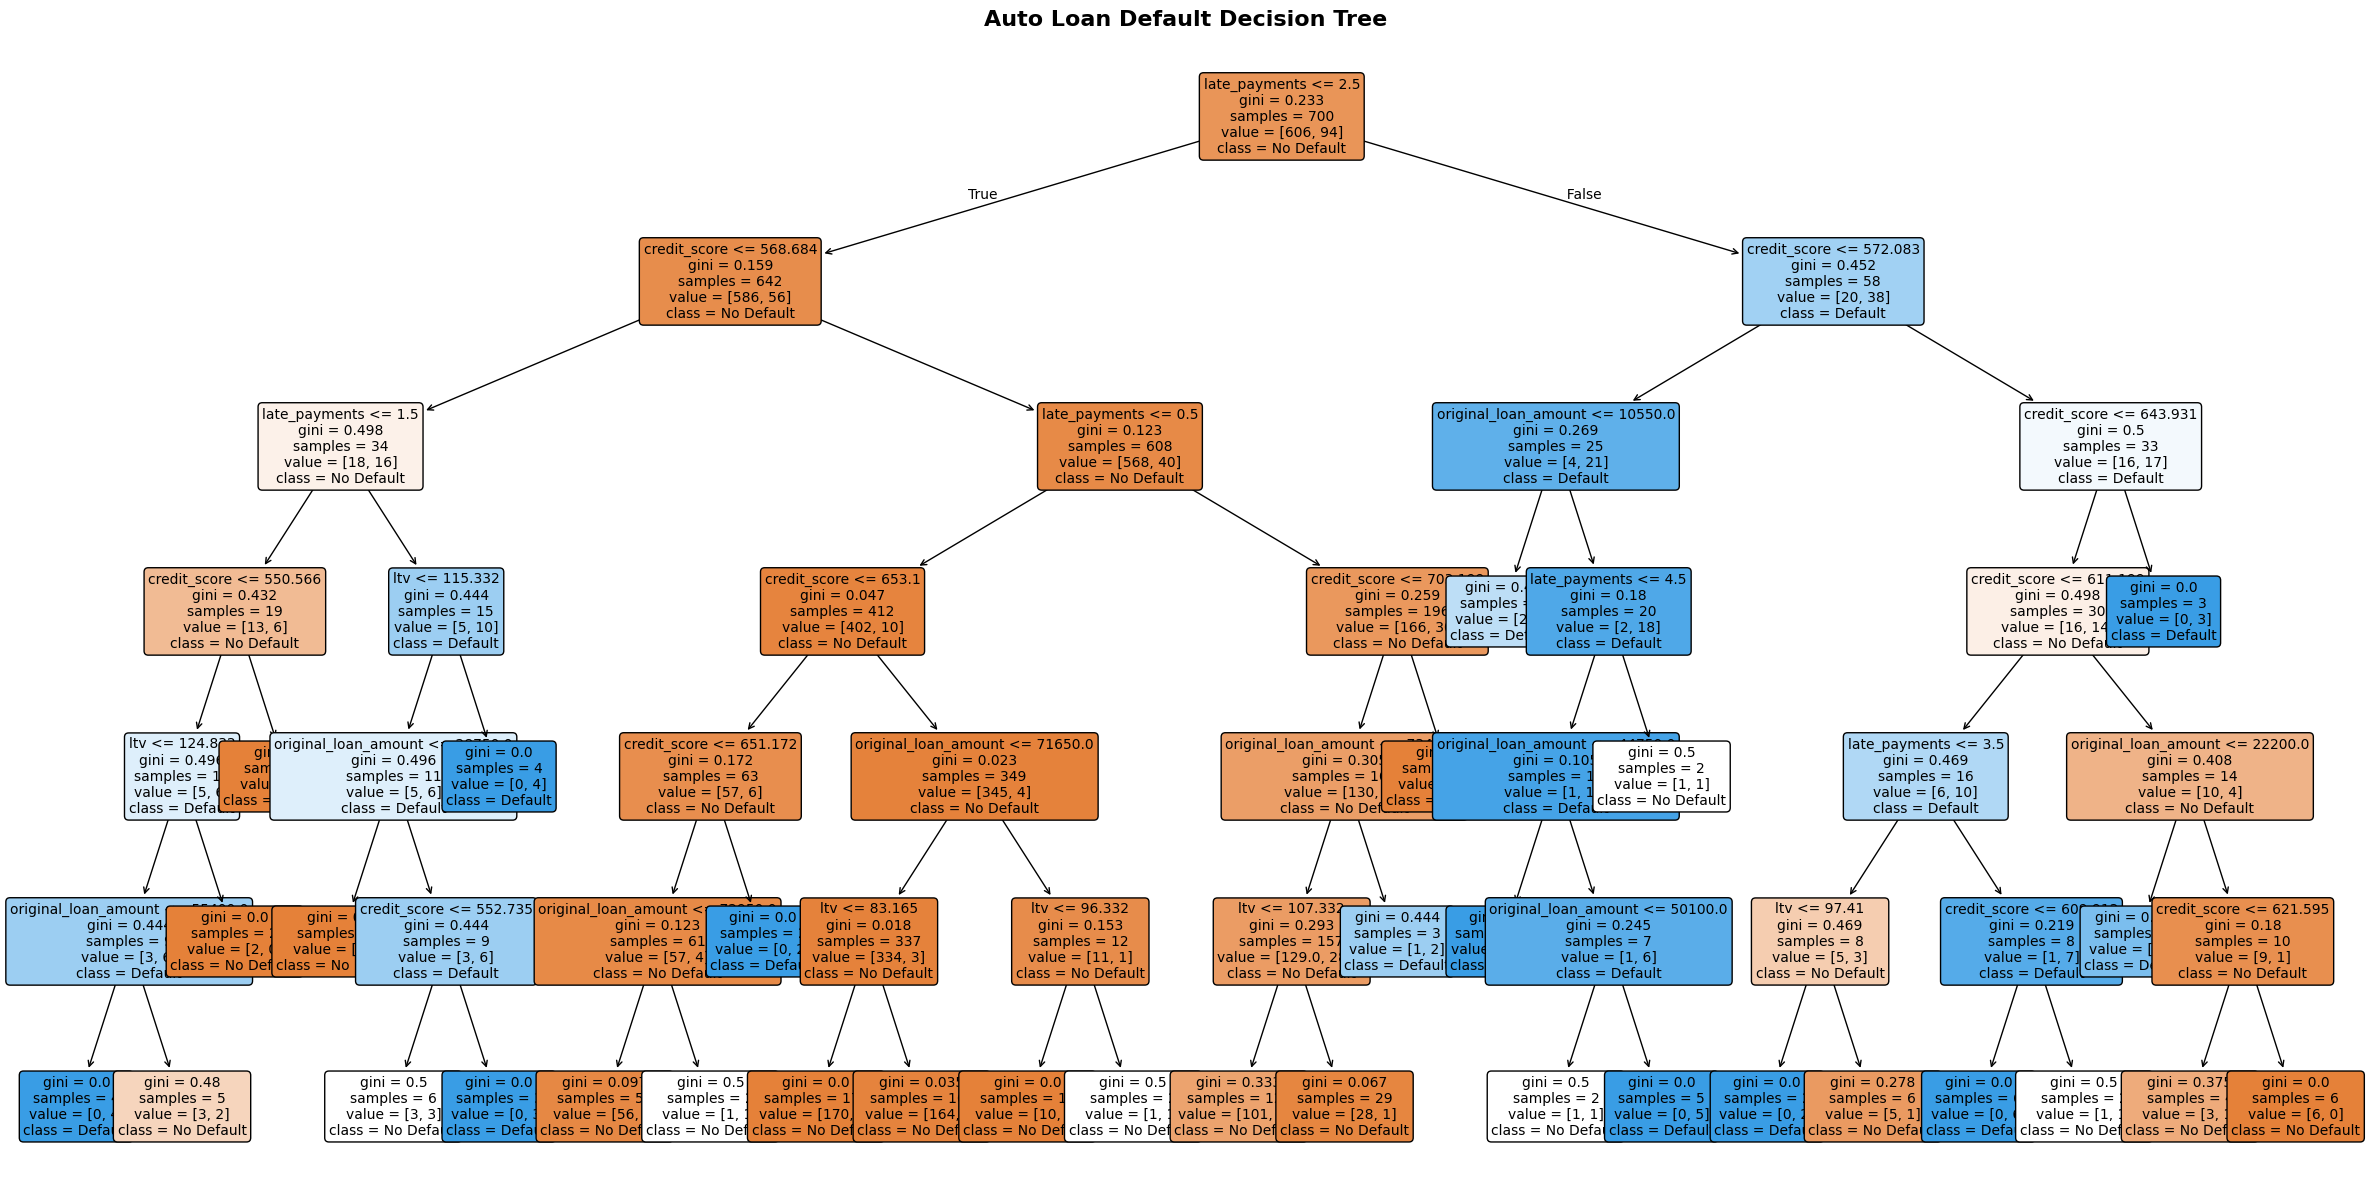

In [25]:
optimized_clf = DecisionTreeClassifier(max_depth = 6, min_samples_leaf=2, min_samples_split=7, random_state=seed)
optimized_clf.fit(X_train, y_train)

# Predict on the test set
optimized_y_pred = optimized_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Check what features you're actually using
print("Features:", X.columns.tolist())

# Look at the decision tree depth/complexity
print("Tree depth:", optimized_clf.get_depth())
print("Number of leaves:", optimized_clf.get_n_leaves())

# Check feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': optimized_clf.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance)
plt.figure(figsize=(15, 10))
feature_importance.plot(kind='barh', x='feature', y='importance', legend=False)
plt.title('Feature Importances')
plt.show()

# Create a large, readable tree visualization
plt.figure(figsize=(30, 15))
plot_tree(optimized_clf, 
          feature_names=X.columns, 
          class_names=['No Default', 'Default'], 
          filled=True, 
          rounded=True,
          fontsize=10)
plt.title('Auto Loan Default Decision Tree', fontsize=16, fontweight='bold')
plt.show()

In [26]:
optimized_y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [27]:


# Find loans where predictions differ
different_predictions = y_pred != optimized_y_pred

# Get the actual outcomes for these loans
actual_outcomes = y_test[different_predictions]
baseline_wrong = y_pred[different_predictions]
optimized_correct = optimized_y_pred[different_predictions]

# Identify where optimized model was right and baseline was wrong
improvement_mask = (actual_outcomes != baseline_wrong) & (actual_outcomes == optimized_correct)
improved_loans = X_test[different_predictions][improvement_mask]

print(f"Number of loans where optimized model outperformed baseline: {improvement_mask.sum()}")
print("\nCharacteristics of improved predictions:")
print(improved_loans.describe())

Number of loans where optimized model outperformed baseline: 5

Characteristics of improved predictions:
       original_loan_amount  credit_score         ltv  late_payments  \
count               5.00000      5.000000    5.000000       5.000000   
mean            46880.00000    598.242566  112.268747       2.600000   
std             24615.38137     36.655092   11.790753       0.894427   
min              7300.00000    550.000000   92.974099       1.000000   
25%             38600.00000    578.424801  112.422778       3.000000   
50%             58800.00000    596.440420  113.066069       3.000000   
75%             64300.00000    622.910676  118.710349       3.000000   
max             65400.00000    643.436933  124.170438       3.000000   

       vehicle_type_encoded  
count              5.000000  
mean               0.600000  
std                0.547723  
min                0.000000  
25%                0.000000  
50%                1.000000  
75%                1.000000  
max   

In [28]:
test_set_size = len(X_test)  # Let's say ~300 loans in test set
improvement_loans = 5
portfolio_size = 1000  # Annual loan volume

# Scale up the improvement
annual_improvement = (improvement_loans / test_set_size) * portfolio_size
# = (5 / 300) * 1000 = 16.67 ≈ 17 borrowers